In [1]:
import random
import cv2
import pickle
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

In [2]:
# specify dataset and annotation directories
data_dir = 'dataset'
data_type = 'val2017'
ann_file = '{}/annotations/instances_{}.json'.format(data_dir, data_type)

## Create one-hot supercategory vector for each image

In [3]:
# initialize coco api
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [4]:
# display COCO categories
categories = coco.loadCats(coco.getCatIds())
names = [category['name'] for category in categories]
print('COCO categories: \n{}\n'.format(' '.join(names)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [5]:
# display COCO supercategories
supercategories = set([category['supercategory'] for category in categories])
print('COCO supercategories: \n{}'.format(' '.join(supercategories)))

COCO supercategories: 
furniture animal electronic outdoor person sports food vehicle kitchen accessory appliance indoor


In [6]:
# Assign id to each supercategory
print('ID', 'Supercategory', sep='\t')
print('-' * 22)
supercategory_ids = {}
for idx, supercategory in enumerate(supercategories):
    supercategory_ids[supercategory] = idx
    print(idx, supercategory, sep='\t')

ID	Supercategory
----------------------
0	furniture
1	animal
2	electronic
3	outdoor
4	person
5	sports
6	food
7	vehicle
8	kitchen
9	accessory
10	appliance
11	indoor


In [7]:
# Create a dictionary
# key: supercategory
# value: 'set' of corresponding image ids

supercategory_to_img = {}
for category in categories:
    supercategory = category['supercategory']
    category_id = coco.getCatIds(catNms=category['name'])
    img_ids = coco.getImgIds(catIds=category_id)
    if supercategory in supercategory_to_img:
        supercategory_to_img[supercategory] |= set(img_ids)
    else:
        supercategory_to_img[supercategory] = set(img_ids)

In [8]:
# Create a dictionary
# key: image id
# value: one-hot vector of supercategories the image belongs to

image_to_supercategories = {}
for supercategory, img_ids in supercategory_to_img.items():
    for img_id in img_ids:
        if img_id in image_to_supercategories:
            image_to_supercategories[img_id][supercategory_ids[supercategory]] = 1
        else:
            one_hot = [0] * len(supercategories)
            one_hot[supercategory_ids[supercategory]] = 1
            image_to_supercategories[img_id] = one_hot

In [9]:
list(image_to_supercategories.items())[:5]

[(532481, [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 (458755, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]),
 (385029, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
 (311303, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
 (393226, [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])]

## Parse an image from the dataset

In [10]:
# Get Image
img = coco.loadImgs([532481])[0]

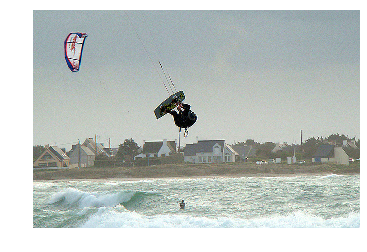

In [11]:
# load and display image
I = io.imread('%s/%s/%s'%(data_dir, data_type, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

In [12]:
# get image description
img

{'license': 3,
 'file_name': '000000532481.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-20 16:28:24',
 'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg',
 'id': 532481}

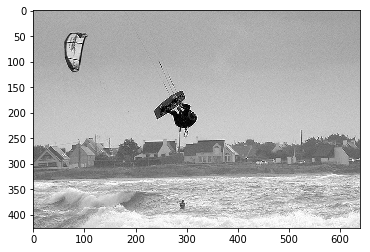

In [13]:
for img_id, supercategory in image_to_supercategories.items():
    img = coco.loadImgs([img_id])[0]
    img_path = '%s/%s/%s' % (data_dir, data_type, img['file_name'])
    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break

In [14]:
img_array.shape

(426, 640)

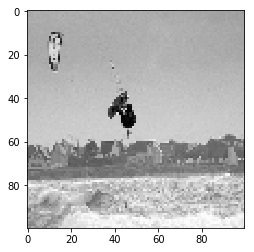

In [15]:
img_size = 100
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(new_array, cmap='gray')
plt.show()

## Create training dataset

In [16]:
img_size = 100

def create_training_data():
    training_data = []
    for img_id, supercategory in image_to_supercategories.items():
        img = coco.loadImgs([img_id])[0]
        img_array = cv2.imread('%s/%s/%s' % (data_dir, data_type, img['file_name']), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_img_array, supercategory])
    random.shuffle(training_data) # shuffle items to reduce homogeneity
    return training_data

In [18]:
training_data = create_training_data()

In [19]:
# View the first input and corresponding label
training_data[0]

[array([[169, 171, 171, ..., 161, 157, 159],
        [174, 167, 170, ..., 160, 157, 154],
        [166, 167, 169, ..., 162, 162, 159],
        ...,
        [152, 138, 137, ..., 231, 227, 230],
        [137, 129, 134, ..., 231, 233, 231],
        [162, 139, 170, ..., 241, 228, 212]], dtype=uint8),
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [20]:
# Size of the dataset
len(training_data)

4925

In [21]:
X = []
y = []

In [22]:
for features, label in training_data:
    X.append(features)
    y.append(label)

In [23]:
X = np.array(X)
X.shape

(4925, 100, 100)

In [24]:
X = X.reshape(-1, img_size, img_size, 1)  # last dimension is to specify grayscale image

In [25]:
X.shape

(4925, 100, 100, 1)

## Save and load dataset

In [26]:
# Save dataset to disk
pickle_out_x = open('X.pickle', 'wb')
pickle.dump(X, pickle_out_x)
pickle_out_x.close()

pickle_out_y = open('y.pickle', 'wb')
pickle.dump(y, pickle_out_y)
pickle_out_y.close()

In [ ]:
# Load dataset from disk
pickle_in_x = open('X.pickle', 'rb')
X = pickle.load(pickle_in_x)

pickle_in_y = open('y.pickle', 'rb')
y = pickle.load(pickle_in_y)

In [ ]:
X.shape

In [ ]:
len(y)